In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import itertools
import statsmodels.api as sm

In [2]:
df = pd.read_csv('FSOData.csv')
df.shape

(91379, 11)

In [3]:
df.head()

,FSO_Att,Absolute Humidity,Wind Speed,Visibility,Time,Wind Speed Max,Temperature,Temperature Difference,Particulate,Distance,SYNOP Code
0,7.913289,17.595709,3.057066,65884.51846,9,6.863808,26.067846,13.63,0.0,2115.338398,0
1,7.451176,17.549693,2.727910,64963.41092,9,6.468903,25.645703,-0.54,0.0,2113.999257,0
2,7.072747,17.290230,1.674810,54794.28107,10,2.826916,25.653383,-0.24,0.0,2118.689047,0
3,6.949288,16.820880,0.962068,50205.64159,10,2.780643,25.646271,-0.16,0.0,2114.632339,0
4,7.361052,16.813820,1.881007,59038.32599,10,4.476298,25.673089,-0.10,0.0,2116.786055,0


In [4]:
synop_onehot = pd.get_dummies(df['SYNOP Code'], prefix='SYNOP')
df = pd.concat([df, synop_onehot], axis=1)
df = df.drop('SYNOP Code', axis=1)

df.head()

,FSO_Att,Absolute Humidity,Wind Speed,Visibility,Time,Wind Speed Max,Temperature,Temperature Difference,Particulate,Distance,SYNOP_0,SYNOP_3,SYNOP_4,SYNOP_5,SYNOP_6,SYNOP_7,SYNOP_8
0,7.913289,17.595709,3.057066,65884.51846,9,6.863808,26.067846,13.63,0.0,2115.338398,1,0,0,0,0,0,0
1,7.451176,17.549693,2.727910,64963.41092,9,6.468903,25.645703,-0.54,0.0,2113.999257,1,0,0,0,0,0,0
2,7.072747,17.290230,1.674810,54794.28107,10,2.826916,25.653383,-0.24,0.0,2118.689047,1,0,0,0,0,0,0
3,6.949288,16.820880,0.962068,50205.64159,10,2.780643,25.646271,-0.16,0.0,2114.632339,1,0,0,0,0,0,0
4,7.361052,16.813820,1.881007,59038.32599,10,4.476298,25.673089,-0.10,0.0,2116.786055,1,0,0,0,0,0,0


In [5]:
df.isnull().sum()

FSO_Att                   0
Absolute Humidity         0
Wind Speed                0
Visibility                0
Time                      0
Wind Speed Max            0
Temperature               0
Temperature Difference    0
Particulate               0
Distance                  0
SYNOP_0                   0
SYNOP_3                   0
SYNOP_4                   0
SYNOP_5                   0
SYNOP_6                   0
SYNOP_7                   0
SYNOP_8                   0
dtype: int64

In [6]:
df.duplicated().sum()

0

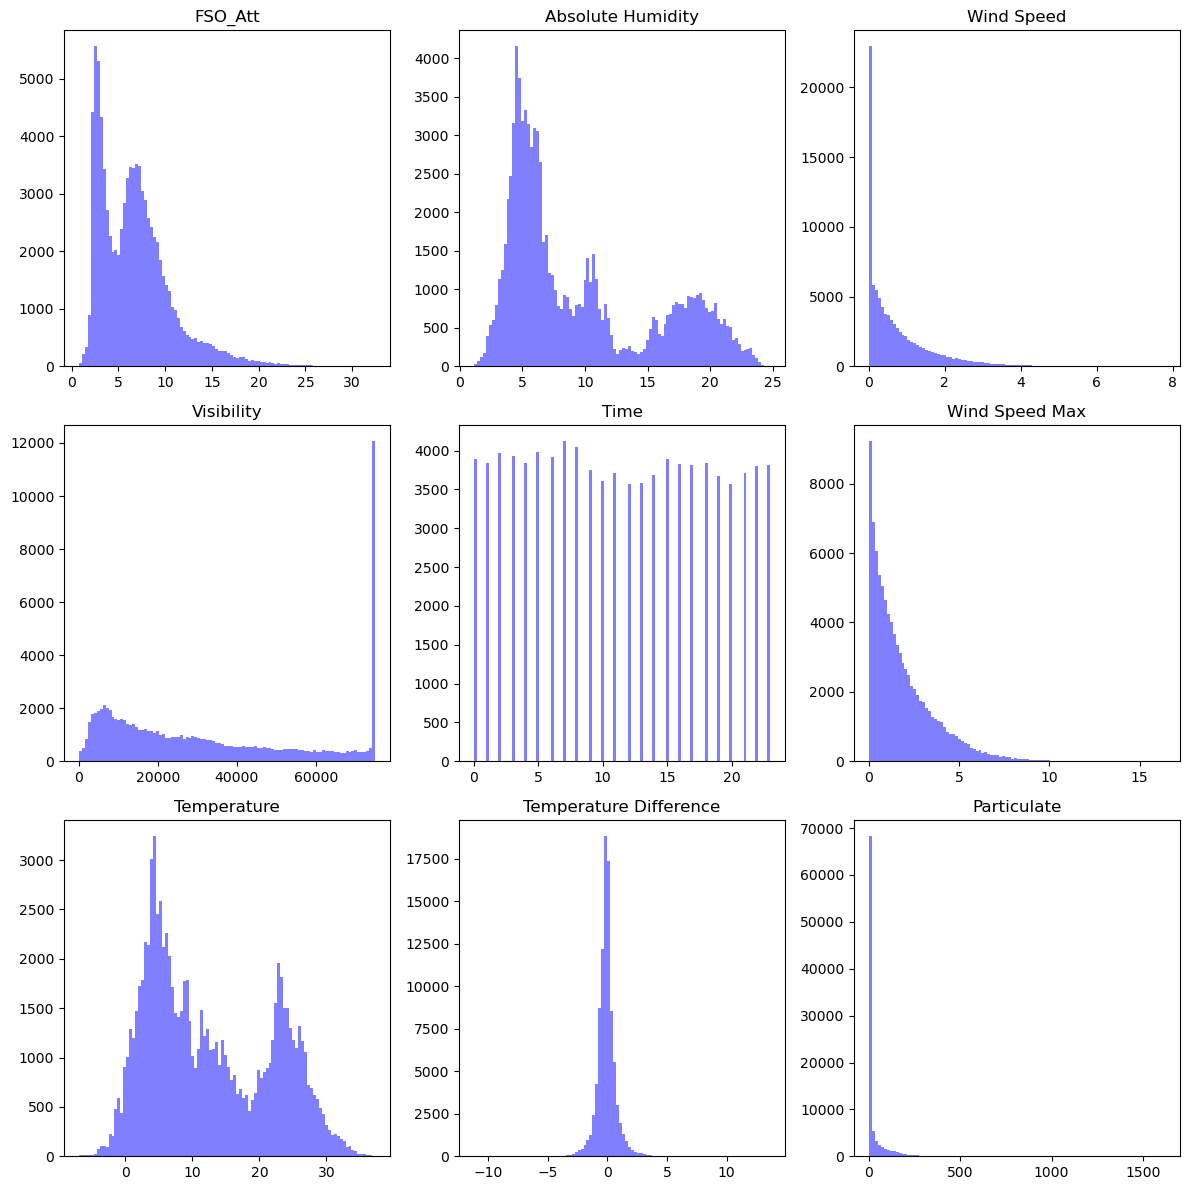

In [7]:
non_categorical_columns = [col for col in df.columns if ("SYNOP" not in col)]
df_non_categorical = df[non_categorical_columns]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.hist(df_non_categorical.iloc[:, i], bins=100, alpha=0.5, color='b')
    ax.set_title(df_non_categorical.columns[i])

fig.tight_layout()

plt.show()

# Linear Regression 

In [8]:
# Initialize the LinearRegression model
regressor = LinearRegression()

# Create the linear regression pipeline
# lr_pipe = Pipeline([("standard scaler", StandardScaler()), 
#                  ("regressor", regressor)])

lr_pipe = Pipeline([("regressor", regressor)])

train_set, test_set = train_test_split(df, test_size = 0.4, random_state = 42)
# We use valid set data to compare the performance of different models

X_train = train_set.drop("FSO_Att", axis=1)
y_train = train_set["FSO_Att"]

X_test = test_set.drop("FSO_Att", axis=1)
y_test = test_set["FSO_Att"]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(54827, 16) (54827,)
(36552, 16) (36552,)


In [9]:
def train_pipeline(pipeline, train_set = X_train, test_set = X_test):
    pipeline.fit(train_set, y_train)
    train_mse = mean_squared_error(y_train, pipeline.predict(train_set))
    test_mse = mean_squared_error(y_test, pipeline.predict(test_set))
    train_r2 = r2_score(y_train, pipeline.predict(train_set))
    test_r2 = r2_score(y_test, pipeline.predict(test_set))
    print("MSE train:", train_mse)
    print("MSE test:", test_mse)
    print("R2 train:", train_r2)
    print("R2 test:", test_r2)
    return {"pipeline" : pipeline, "train_mse" : train_mse, "test_mse" : test_mse, "train_r2" : train_r2, "test_r2" : test_r2, "predictos" : train_set.shape[1]}


def print_equation(model, X_train = X_train):
    print("y = ", end="")
    for i in range(len(model.coef_)):
        if model.coef_[i] != 0:
            print(f"{model.coef_[i]} * {X_train.columns[i]} + ", end="")
    print(f"{model.intercept_}")

lr_pipe = Pipeline([("regressor", LinearRegression())])
lr_pipe = train_pipeline(lr_pipe)['pipeline']
print_equation(lr_pipe['regressor'])

MSE train: 9.016562749298703
MSE test: 8.87614746003276
R2 train: 0.4106906897078103
R2 test: 0.414034265724913
y = 0.2730257158869162 * Absolute Humidity + 0.048339025968726496 * Wind Speed + -3.8486668660964174e-05 * Visibility + -0.04274917037630413 * Time + 0.04880902691313176 * Wind Speed Max + -0.0682021994273455 * Temperature + 0.027429292803466097 * Temperature Difference + 0.01901983242890639 * Particulate + 0.001149936540728497 * Distance + -0.9944867021346142 * SYNOP_0 + 3.8797036802591753 * SYNOP_3 + 0.29356105470485566 * SYNOP_4 + -1.4304566562559635 * SYNOP_5 + -1.9344561582273907 * SYNOP_6 + 1.9518802230646513 * SYNOP_7 + -1.7657454414107108 * SYNOP_8 + 3.6270376872421544


# Linear Regression with Interaction 

In [10]:
print(df.columns)

Index(['FSO_Att', 'Absolute Humidity', 'Wind Speed', 'Visibility', 'Time',
       'Wind Speed Max', 'Temperature', 'Temperature Difference',
       'Particulate', 'Distance', 'SYNOP_0', 'SYNOP_3', 'SYNOP_4', 'SYNOP_5',
       'SYNOP_6', 'SYNOP_7', 'SYNOP_8'],
      dtype='object')


In [11]:
df2 = df.copy()
categorical_columns = []
for col in df2.columns:
    if ("SYNOP" in col) or ("Time" in col):
        categorical_columns.append(col)
# print(categorical_columns)

feature_columns = df2.columns.drop(categorical_columns + ['FSO_Att'])

combinaisons = list(itertools.combinations(feature_columns, 2))

for a, b in combinaisons:
    df2["{a} * {b}".format(a = a, b = b)] = df2[a] * df2[b]
    
for col in feature_columns:
    df2["{}^2".format(col)] = df2[col] ** 2

for col in feature_columns:
    for cat in categorical_columns:
        df2["{} * {}".format(col, cat)] = df2[col] * df2[cat]



/var/folders/k1/l4fpqgbn5hq_02pxbp2s7zkh0000gn/T/ipykernel_36674/2259310197.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2["{} * {}".format(col, cat)] = df2[col] * df2[cat]
/var/folders/k1/l4fpqgbn5hq_02pxbp2s7zkh0000gn/T/ipykernel_36674/2259310197.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2["{} * {}".format(col, cat)] = df2[col] * df2[cat]
/var/folders/k1/l4fpqgbn5hq_02pxbp2s7zkh0000gn/T/ipykernel_36674/2259310197.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

In [12]:
train_set, test_set = train_test_split(df2, test_size = 0.4, random_state = 42)

X_train = train_set.drop("FSO_Att", axis=1)
y_train = train_set["FSO_Att"]

X_test = test_set.drop("FSO_Att", axis=1)
y_test = test_set["FSO_Att"]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(54827, 116) (54827,)
(36552, 116) (36552,)


## Interaction model baseline

In [13]:
lr_interaction_pipe = Pipeline([("regressor", LinearRegression())])
lr_interaction_pipe.fit(X_train, y_train)

train_pred = lr_interaction_pipe.predict(X_train)
test_pred = lr_interaction_pipe.predict(X_test)
print("MSE train:", mean_squared_error(y_train, train_pred))
print("MSE test:", mean_squared_error(y_test, test_pred))
print("R2 train:", r2_score(y_train, train_pred))
print("R2 test:", r2_score(y_test, test_pred))

MSE train: 4.826129096537788
MSE test: 4.731420854801116
R2 train: 0.6845712841644714
R2 test: 0.6876515957140528


## Backward select features

In [14]:
def backward_selection(X, y, threshold = 0.05):
    remain_features = list(X.columns)
    
    while True:
        X_current = sm.add_constant(X[remain_features])
        model = sm.OLS(y, X_current).fit()
        
        # calculate p-values
        pvalues = model.pvalues.drop("const")
        
        # find the feature with the largest p-value
        max_pvalue = pvalues.max()
        max_pvalue_feature = pvalues.idxmax()
        
        print("Current number of features:", len(remain_features))
        print("Largest p-value:", max_pvalue)
        print("Feature with largest p-value:", max_pvalue_feature)
        print("--------------------")
        
        # if the largest p-value is larger than the threshold, remove the feature
        if max_pvalue > threshold:
            remain_features.remove(max_pvalue_feature)
        else:
            break
    
    return remain_features

In [15]:
selected_features = backward_selection(X_train, y_train)

Current number of features: 116
Largest p-value: 0.9554112998798434
Feature with largest p-value: Wind Speed Max * SYNOP_4
--------------------
Current number of features: 115
Largest p-value: 0.9487225365180847
Feature with largest p-value: Visibility * SYNOP_8
--------------------
Current number of features: 114
Largest p-value: 0.8780968483740437
Feature with largest p-value: Particulate * SYNOP_5
--------------------
Current number of features: 113
Largest p-value: 0.797667613925708
Feature with largest p-value: Temperature * SYNOP_0
--------------------
Current number of features: 112
Largest p-value: 0.7845022310050318
Feature with largest p-value: Wind Speed Max
--------------------
Current number of features: 111
Largest p-value: 0.760723522280528
Feature with largest p-value: Time
--------------------
Current number of features: 110
Largest p-value: 0.6612413665663699
Feature with largest p-value: Wind Speed Max * Particulate
--------------------
Current number of features: 10

In [16]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [17]:
lr_interaction_pipe = Pipeline([("regressor", LinearRegression())])
lr_interaction_pipe = train_pipeline(lr_interaction_pipe, train_set=X_train, test_set=X_test)["pipeline"]

MSE train: 4.827275554246003
MSE test: 4.732948368987087
R2 train: 0.684496353370987
R2 test: 0.6875507556845661


## Further delete features

In [18]:
coefficients = lr_interaction_pipe["regressor"].coef_
feature_variance = np.var(X_train, axis = 0)
variance_multiplied = coefficients**2 * feature_variance
variance_multiplied

Absolute Humidity         12.094311
Wind Speed                 0.049832
Visibility                 1.330923
Temperature                0.967612
Temperature Difference     0.169917
                            ...    
Distance * SYNOP_4         1.185352
Distance * SYNOP_5        10.474373
Distance * SYNOP_6        34.626562
Distance * SYNOP_7         0.817079
Distance * SYNOP_8         1.804429
Length: 93, dtype: float64

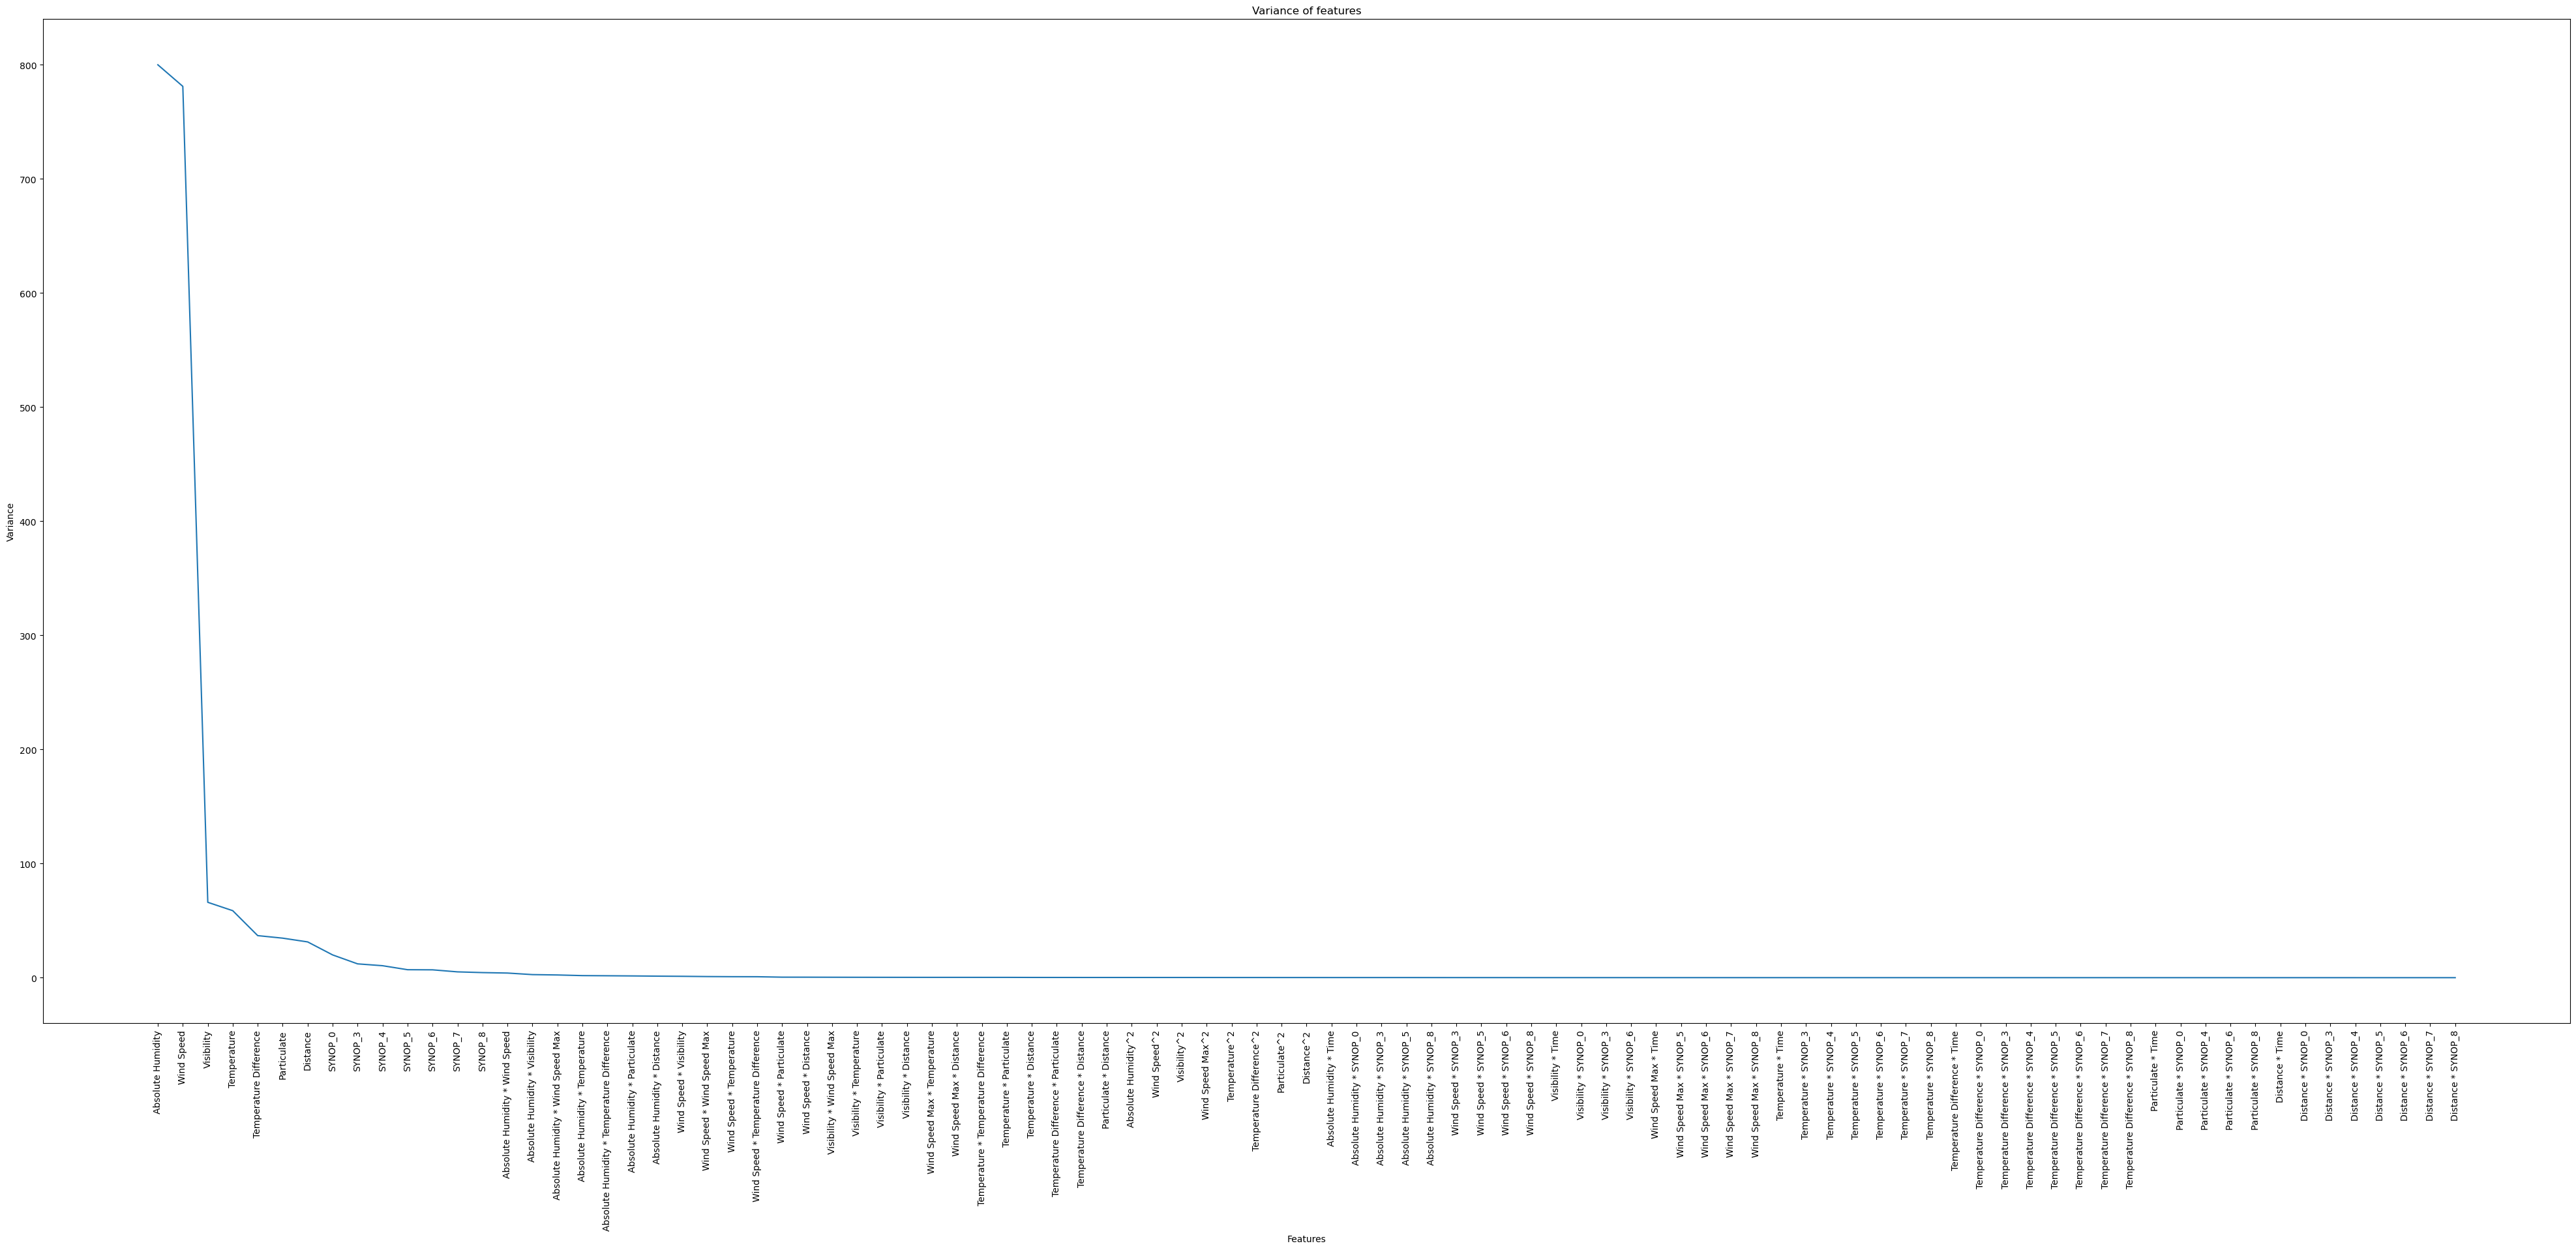

In [19]:
sorted_feature_variance = sorted(variance_multiplied, reverse = True)
plt.figure(figsize=(50, 20))
plt.plot(sorted_feature_variance)
plt.xlabel("Features")
plt.ylabel("Variance")
plt.xticks(range(len(sorted_feature_variance)), X_train.columns, rotation = 90)
# plt.yticks(sorted_feature_variance)
plt.title("Variance of features")
plt.savefig("./", dpi = 600, bbox_inches = "tight")
plt.show()

In [20]:
def feature_select_thresold(threshold):
    important_features = variance_multiplied > threshold
    important_features_indices = np.where(important_features)[0]
    print("-------------------------------------------------------------------------")
    print("Current threshold:", threshold)
    print("Current Number of features:", len(important_features_indices))
    # print("---------------------", "Trying Model with", len(important_features_indices), "features", "--------------------")
    # print(important_features_indices)
    train_set = X_train.iloc[:, important_features_indices]
    test_set = X_test.iloc[:, important_features_indices]
    
    # lr_interaction_pipe = Pipeline([("standard_scaler", StandardScaler()), 
    #                          ("regressor", LinearRegression())])
    
    lr_interaction_pipe = Pipeline([("regressor", LinearRegression())])
    
    lr_interaction_pipe.fit(train_set, y_train)
    train_mse = mean_squared_error(y_train, lr_interaction_pipe.predict(train_set))
    test_mse = mean_squared_error(y_test, lr_interaction_pipe.predict(test_set))
    train_r2 = r2_score(y_train, lr_interaction_pipe.predict(train_set))
    test_r2 = r2_score(y_test, lr_interaction_pipe.predict(test_set))

    return {"pipeline" : lr_interaction_pipe, "train_mse" : train_mse, "test_mse" : test_mse, "train_r2" : train_r2, "test_r2" : test_r2, "predictors" : len(important_features_indices)}

In [21]:
thresholds = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 10, 20, 30, 40, 50]
train_mses = []
test_mses = []
train_r2s = []
test_r2s = []
n_features = []
for threshold in thresholds:
    result = feature_select_thresold(threshold)
    n_feature = result["predictors"]
    train_mse = result["train_mse"]
    test_mse = result["test_mse"]
    train_r2 = result["train_r2"]
    test_r2 = result["test_r2"]
    
    n_features.append(n_feature)
    train_mses.append(train_mse)
    test_mses.append(test_mse)
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)

print("Thresholds: ", thresholds)
print("Number of features: ", n_features)
print("Train MSE: ", train_mses)
print("Test MSE: ", test_mses)
print("Train R2: ", train_r2s)
print("Test R2: ", test_r2s)

-------------------------------------------------------------------------
Current threshold: 0.0001
Current Number of features: 93
-------------------------------------------------------------------------
Current threshold: 0.0005
Current Number of features: 91
-------------------------------------------------------------------------
Current threshold: 0.001
Current Number of features: 89
-------------------------------------------------------------------------
Current threshold: 0.005
Current Number of features: 83
-------------------------------------------------------------------------
Current threshold: 0.01
Current Number of features: 78
-------------------------------------------------------------------------
Current threshold: 0.05
Current Number of features: 56
-------------------------------------------------------------------------
Current threshold: 0.1
Current Number of features: 51
-------------------------------------------------------------------------
Current threshold:

In [22]:
def visulize_thresold_result(thresholds, train_result, test_result, metric):
    fig, ax = plt.subplots(figsize = (20, 8))

    ax.plot(np.arange(len(thresholds)), train_result, label = f"train_{metric}", marker = 'o')
    ax.plot(np.arange(len(thresholds)), test_result, label = f"test_{metric}", marker = 'o')
    
    xticks = np.linspace(0, len(thresholds) - 1, len(thresholds))
    ax.set_xlabel("Threshold")
    ax.set_ylabel(metric)
    ax.set_xticks(xticks)
    ax.set_xticklabels(thresholds)
    ax.set_title(f"{metric} vs Threshold")

    ax.legend()
    plt.show()
    

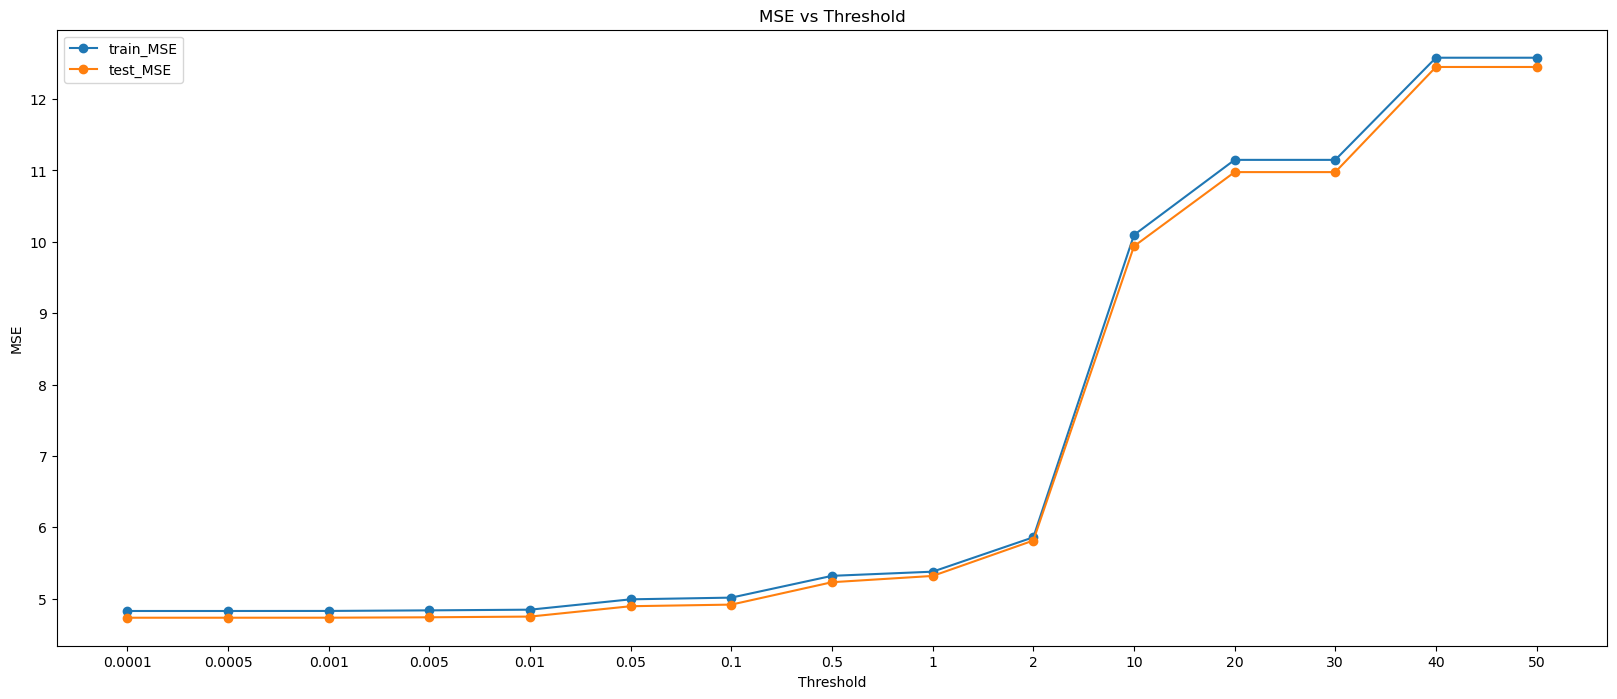

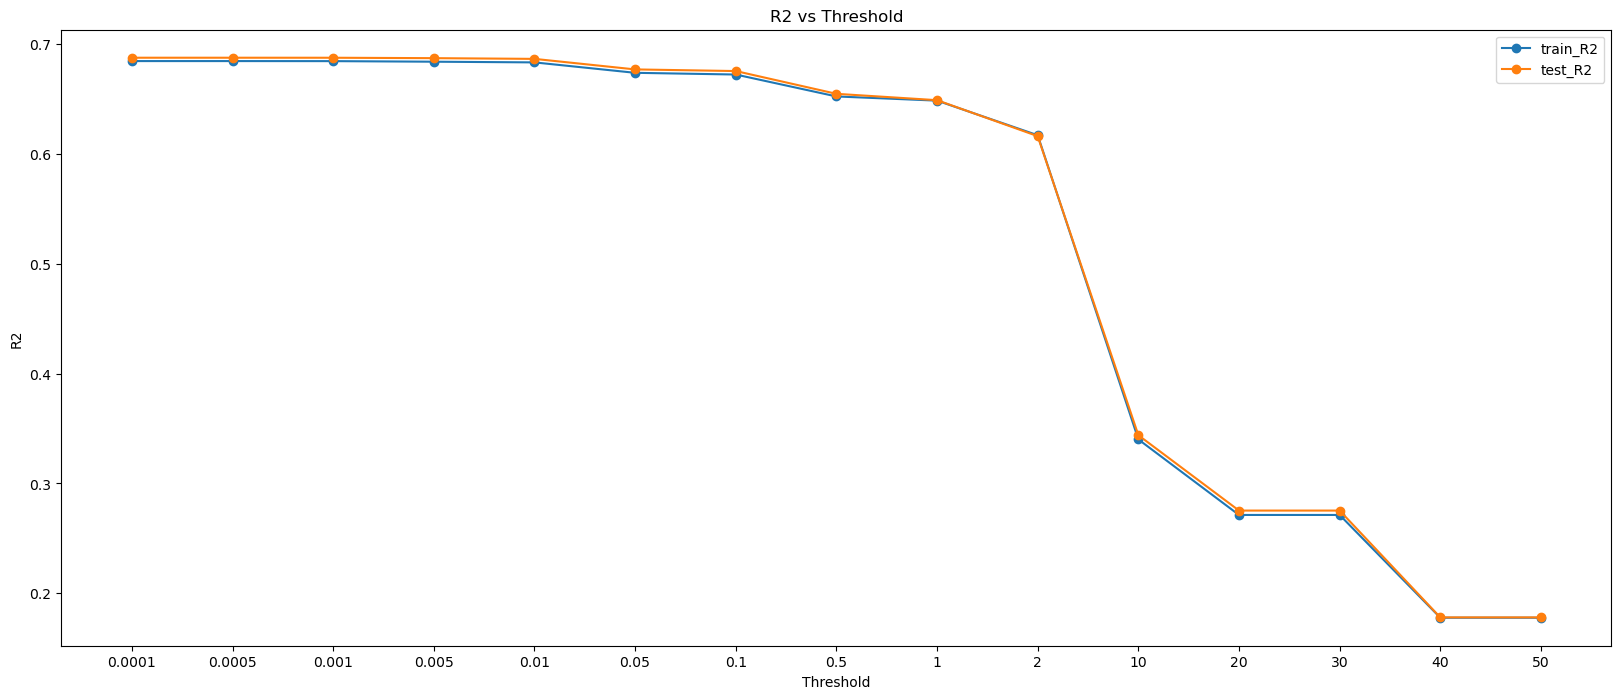

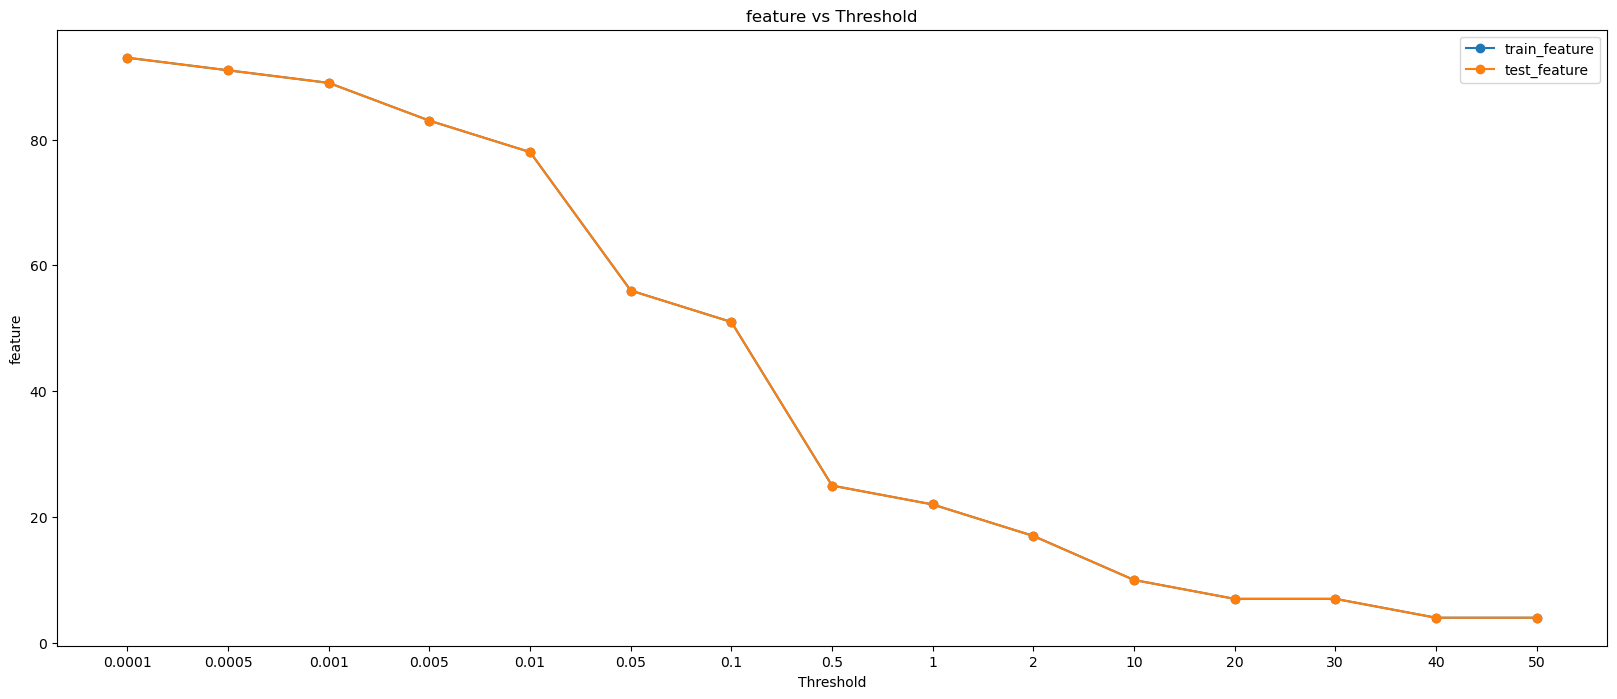

In [23]:
visulize_thresold_result(thresholds, train_mses, test_mses, "MSE")
visulize_thresold_result(thresholds, train_r2s, test_r2s, "R2")
visulize_thresold_result(thresholds, n_features, n_features, "feature")

In [24]:
result = feature_select_thresold(1)
print(result["train_mse"])
print(result["test_mse"])
print(result['train_r2'])
print(result['test_r2'])

-------------------------------------------------------------------------
Current threshold: 1
Current Number of features: 22
5.378105137532865
5.318406927274344
0.6484949401006626
0.6489012565027261


In [25]:
print_equation(result['pipeline']['regressor'], X_train)

y = 0.5117147986858852 * Absolute Humidity + -6.43405032361335e-05 * Wind Speed + 0.031350622673450006 * Visibility + 0.025689281154172582 * Temperature + -3.129105599892149 * Temperature Difference + 0.053139156126584056 * Particulate + -0.018231378215493102 * Distance + 0.0024871035930607898 * SYNOP_0 + -0.0001839157539682861 * SYNOP_3 + -3.049482737349062e-06 * SYNOP_4 + -1.0511163260106973e-08 * SYNOP_5 + -0.0029148290350012552 * SYNOP_6 + -0.00011458928404222568 * SYNOP_7 + 0.011750914362752914 * SYNOP_8 + 1.1639456072955797e-09 * Absolute Humidity * Wind Speed + 0.020230109545292276 * Absolute Humidity * Visibility + -3.2949802987985345e-06 * Absolute Humidity * Wind Speed Max + -0.00030755794417500394 * Absolute Humidity * Temperature + -0.0005081588361222693 * Absolute Humidity * Temperature Difference + -0.000346021300295988 * Absolute Humidity * Particulate + 0.0004890271387170781 * Absolute Humidity * Distance + -0.00048561758308732716 * Wind Speed * Visibility + -32.8254952

# Random Forest

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import itertools
import statsmodels.api as sm
df = pd.read_csv("FSOData.csv")
for columns in df.columns:
    if "Unnamed" in columns:
        df.drop(columns, axis=1, inplace=True)
synop_onehot = pd.get_dummies(df["SYNOP Code"], prefix = "SYNOP")
df = pd.concat([df, synop_onehot], axis=1)
df = df.drop("SYNOP Code", axis=1)

In [27]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor()

lr_pipe = Pipeline([("regressor", regressor)])

train_set, test_set = train_test_split(df, test_size = 0.8, random_state = 42)

X_train = train_set.drop("FSO_Att", axis=1)
y_train = train_set["FSO_Att"]

X_test = test_set.drop("FSO_Att", axis=1)
y_test = test_set["FSO_Att"]


lr_pipe.fit(X_train, y_train)
train_mse = mean_squared_error(y_train, lr_pipe.predict(X_train))
test_mse = mean_squared_error(y_test, lr_pipe.predict(X_test))
train_r2 = r2_score(y_train, lr_pipe.predict(X_train))
test_r2 = r2_score(y_test, lr_pipe.predict(X_test))
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)
print("Train R2:", train_r2)
print("Test R2:", test_r2)

Train MSE: 0.17076676799078397
Test MSE: 1.2086047048860382
Train R2: 0.9887526964807847
Test R2: 0.9207681549738306


In [28]:
from sklearn.model_selection import GridSearchCV

regressor = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 200, 500],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
}

grid_search = GridSearchCV(regressor, param_grid, cv = 10, scoring = "neg_mean_squared_error", return_train_score = True)

grid_search.fit(X_train, y_train)


print("Best Parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)



KeyboardInterrupt: 

In [ ]:
best_rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)

best_rf.fit(X_train, y_train)

y_test_pred = best_rf.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

y_train_pred = best_rf.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
print(f"Optimized TestMSE: {test_mse}")
print(f"Optimized Test R2: {test_r2}")
print(f"Optimized TrainMSE: {train_mse}")
print(f"Optimized Train R2: {train_r2}")

Optimized TestMSE: 1.2055502999975516
Optimized Test R2: 0.9209683909432864
Optimized TrainMSE: 0.15879756087215083
Optimized Train R2: 0.9895410308091294
